### Curve-Fitting

Curve fitting is a way to translate a cross-section of yields for different maturities into a continuous functional form. The aim is to find a model that fits a smooth curve that accurately describes the known datapoints (yield x maturity) and allow us to interpolate the theoretical forward rates between two existing maturities.

The data below corresponds to Brazilian Government Zero Coupon Bond from 2018 to 2024.

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.decomposition import PCA


df = pd.read_excel('/Users/eduardo/Documents/1.PSME/Master Thesis/ettj_18_24_clean_wide.xlsx')
df.head()

,date,yield_1,yield_30,yield_90,yield_180,yield_365,yield_730,yield_1095,yield_1460,yield_1826,yield_2520,yield_3600,yield_5400,yield_7200,yield_10800
0,2018-01-02,6.89,6.90,6.74,6.64,6.81,7.93,8.88,9.47,9.80,10.24,10.61,10.82,10.91,10.99
1,2018-01-03,6.89,6.89,6.72,6.63,6.78,7.92,8.85,9.43,9.75,10.18,10.58,10.78,10.86,10.95
2,2018-01-04,6.89,6.90,6.72,6.62,6.77,7.93,8.83,9.42,9.76,10.20,10.59,10.82,10.90,10.99
3,2018-01-05,6.89,6.88,6.73,6.63,6.80,7.99,8.89,9.46,9.79,10.23,10.62,10.85,10.93,11.02
4,2018-01-08,6.89,6.86,6.71,6.64,6.81,7.98,8.86,9.41,9.74,10.18,10.58,10.80,10.89,10.97


One important step is to know which maturities to use. Although all of them can be used

In [7]:
yield_columns = ['yield_1', 'yield_30', 'yield_90', 'yield_180', 'yield_365', 'yield_730', 'yield_1095', 'yield_1460', 'yield_1826', 'yield_2520', 'yield_3600', 'yield_5400', 'yield_7200', 'yield_10800']

yields = df[yield_columns].dropna()

- explain the importance of pca
- talk about why 4 when 2 already reaches the 95% of variance
-

In [16]:
pca = PCA(n_components=4)
pca.fit(yields)

loadings = pd.DataFrame(pca.components_.T, index=yields.columns, columns=['PC1','PC2','PC3', 'PC4'])

print(loadings)

                  PC1       PC2       PC3       PC4
yield_1      0.357010 -0.406855 -0.378664 -0.294733
yield_30     0.361690 -0.360736 -0.231721 -0.085635
yield_90     0.365791 -0.283814 -0.022383  0.161929
yield_180    0.365256 -0.164141  0.245107  0.360656
yield_365    0.343399  0.009937  0.482342  0.288402
yield_730    0.278972  0.176701  0.416139 -0.191543
yield_1095   0.238513  0.233926  0.207547 -0.353315
yield_1460   0.216563  0.251527  0.045913 -0.353036
yield_1826   0.203442  0.259513 -0.056593 -0.277715
yield_2520   0.186261  0.265058 -0.176164 -0.107575
yield_3600   0.169849  0.264656 -0.257567  0.023186
yield_5400   0.157885  0.271934 -0.275398  0.163783
yield_7200   0.152767  0.282873 -0.251654  0.293534
yield_10800  0.147572  0.293131 -0.227112  0.421843


In [17]:
selected = {}

for pc in loadings.columns:
    max_loading_mat = loadings[pc].abs().idxmax()
    selected[pc] = max_loading_mat

selected

{'PC1': 'yield_90', 'PC2': 'yield_1', 'PC3': 'yield_365', 'PC4': 'yield_10800'}

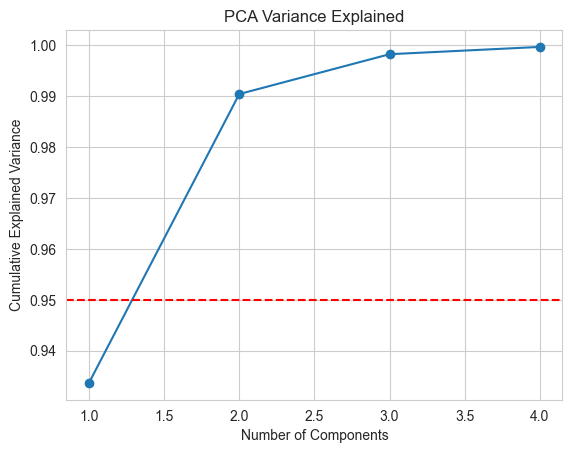

In [18]:
explained = pca.explained_variance_ratio_
cumsum = explained.cumsum()

plt.plot(range(1, len(explained)+1), cumsum, marker='o')
plt.axhline(0.95, color='r', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Variance Explained")
plt.grid(True)
plt.show()

The **Nelson–Siegel (1987)** model was introduced as a parsimonious, smooth, and economically interpretable way to represent the term structure of interest rates using only a few parameters that capture the dominant shapes observed in yield curves.

It models the zero-coupon yield at maturity:

$y(\tau) = \beta_0
+ \beta_1 \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} \right)
+ \beta_2 \left( \frac{1 - e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau} \right)$


 represent the level, slope, and curvature factors of the yield curve, and $λ$ controls the decay rate that determines how quickly the influence of the slope and curvature components diminishes with maturity. This formulation naturally produces the three empirical features that dominate yield curve movements—parallel shifts, steepening/flattening, and hump-shaped patterns—while remaining simple enough for efficient estimation and forecasting, making it a foundational model in modern fixed-income analytics.

In [19]:
def nelson_siegel(tau, beta0, beta1, beta2, lamb):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-lamb * tau)) / (lamb * tau))
    term3 = beta2 * (((1 - np.exp(-lamb * tau)) / (lamb * tau)) - np.exp(-lamb * tau))
    return term1 + term2 + term3

In [22]:
def ns_sse(params, tau, yields):
    """Sum of squared errors for NS curve."""
    beta0, beta1, beta2, lamb = params
    fitted = nelson_siegel(tau, beta0, beta1, beta2, lamb)
    return np.sum((yields - fitted)**2)

In [23]:
def fit_nelson_siegel(tau, yields, initial_guess=None):
    """
    Estimate NS parameters via optimization.
    tau: maturities (array)
    yields: observed yields (array)
    """
    if initial_guess is None:
        # reasonable starting values
        initial_guess = [np.mean(yields), -2, 2, 0.5]

    bounds = [(-5, 15), (-20, 20), (-20, 20), (1e-6, 5)]  # keep λ positive

    result = minimize(ns_sse, initial_guess, args=(tau, yields),
                      bounds=bounds, method='L-BFGS-B')

    params = result.x
    return params, result

In [24]:
def ns_metrics(tau, yields, params):
    """Return SSE, RMSE, and AIC for NS curve."""
    beta0, beta1, beta2, lamb = params
    fitted = nelson_siegel(tau, beta0, beta1, beta2, lamb)

    residuals = yields - fitted
    sse = np.sum(residuals**2)
    rmse = np.sqrt(np.mean(residuals**2))

    k = 4  # number of parameters
    n = len(yields)
    aic = 2*k + n * np.log(sse/n)

    return {"SSE": sse, "RMSE": rmse, "AIC": aic, "fitted": fitted}